# 7. 다대일 RNN 기본 Modeling

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchtext import data, datasets
import random
from torchtext.data import TabularDataset

USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("cpu와 cuda 중 다음 기기로 학습함:", DEVICE)

SEED = 5
random.seed(SEED)
torch.manual_seed(SEED)

cpu와 cuda 중 다음 기기로 학습함: cpu


## 7-1. Review Data 수집 및 전처리

In [2]:
import urllib.request

urllib.request.urlretrieve("https://raw.githubusercontent.com/LawrenceDuan/IMDb-Review-Analysis/master/IMDb_Reviews.csv", filename="IMDb_Reviews.csv")

('IMDb_Reviews.csv', <http.client.HTTPMessage at 0x28a2c456d08>)

In [2]:
import pandas as pd

df = pd.read_csv('IMDb_Reviews.csv', encoding='latin1')
df.head()

,review,sentiment
0,My family and I normally do not watch local mo...,1
1,"Believe it or not, this was at one time the wo...",0
2,"After some internet surfing, I found the ""Home...",0
3,One of the most unheralded great works of anim...,1
4,"It was the Sixties, and anyone with long hair ...",0


In [3]:
print('전체 샘플의 개수 : {}'.format(len(df)))

전체 샘플의 개수 : 50000


In [4]:
# Sample 수가 많으므로, Test용으로 대폭 줄여 새로운 파일을 만든 후 사용
df = pd.read_csv('IMDb_Reviews_200.csv', encoding='latin1')
df.head()

,review,sentiment
0,My family and I normally do not watch local mo...,1
1,"Believe it or not, this was at one time the wo...",0
2,"After some internet surfing, I found the ""Home...",0
3,One of the most unheralded great works of anim...,1
4,"It was the Sixties, and anyone with long hair ...",0


In [5]:
print('전체 샘플의 개수 : {}'.format(len(df)))

전체 샘플의 개수 : 200


### 훈련 데이터, 평가 데이터, 테스트 데이터로 분리

In [6]:
train_df = df[:150]
test_df = df[150:]

In [7]:
train_df.to_csv("train_data.csv", index=False)
test_df.to_csv("test_data.csv", index=False)

## 7-2. Field 정의 및 Dataset 만들기

In [8]:
TEXT = data.Field(sequential=True,lower=True, batch_first=True)
LABEL = data.Field(sequential=False, batch_first=True)

In [9]:
trainset, testset = TabularDataset.splits(
        path='.', train='train_data.csv', test='test_data.csv', format='csv',
        fields=[('text', TEXT), ('label', LABEL)], skip_header=True)    # field: Data column format 정의

### Dataset sample 확인

In [10]:
print('훈련 샘플의 개수 : {}'.format(len(trainset)))
print('테스트 샘플의 개수 : {}'.format(len(testset)))

훈련 샘플의 개수 : 150
테스트 샘플의 개수 : 50


In [11]:
print(trainset[0])

In [12]:
# trainset 내용물 확인
print(vars(testset[0]))

{'text': ['i', 'have', 'seen', 'this', 'movie', 'maybe', 'a', '100', 'times,', 'never', 'grow', 'tired', 'of', 'it.i', 'saw', 'this', 'movie', 'the', 'first', 'time', 'when', 'i', 'was', '7', 'years', 'old,', 'and', 'it', 'has', 'left', 'a', 'mark', 'in', 'my', 'memories', 'since', 'then.', 'its', 'a', 'enchanting', 'love', 'story', 'that', 'brings', 'the', 'sun', 'out', 'in', 'most', 'people,', 'even', 'in', 'the', 'darkest', 'times.', 'i', 'think', 'that', 'this', 'is', 'a', '"must', 'see"', 'movie', 'and', 'one', 'of', 'anthony', "quinn's", 'best', 'performance', 'ever.', 'i', 'just', 'wish', 'that', 'the', 'tv-channels', 'would', 'send', 'this', 'movie', 'more', 'often.', 'it', 'has', 'inspired', 'me', 'in', 'a', 'good', 'way', 'and', 'surly', 'will', 'do', 'that', 'to', 'many', 'others.', 'if', 'there', 'is', 'any', 'actor', 'i', 'wanted', 'to', 'meet,', 'it', 'would', 'have', 'been', 'anthony', 'quinn.', 'there', 'will', 'never', 'be', 'a', 'like', 'of', 'him', 'on', 'the', 'silv

## 7-3. Vocabulary set 만들기

In [13]:
TEXT.build_vocab(trainset, min_freq=5)      # 단어 집합 생성, 단어 수가 적으므로 최소 횟수를 5로 설정
LABEL.build_vocab(trainset)

In [14]:
n_vocab = len(TEXT.vocab)
print('단어 집합의 크기 : {}'.format(n_vocab))

단어 집합의 크기 : 847


In [15]:
# 수집된 전체 단어 확인
print(TEXT.vocab.stoi)

defaultdict(<bound method Vocab._default_unk_index of <torchtext.vocab.Vocab object at 0x000001CE2FE25FC8>>, {'<unk>': 0, '<pad>': 1, 'the': 2, 'and': 3, 'a': 4, 'of': 5, 'to': 6, 'is': 7, 'in': 8, 'i': 9, 'that': 10, 'this': 11, 'it': 12, 'for': 13, 'as': 14, 'with': 15, 'was': 16, '/><br': 17, 'but': 18, 'his': 19, 'not': 20, 'on': 21, 'he': 22, 'film': 23, 'movie': 24, 'by': 25, 'have': 26, 'are': 27, 'be': 28, 'you': 29, 'an': 30, 'one': 31, 'who': 32, 'at': 33, 'so': 34, 'all': 35, 'about': 36, 'from': 37, 'they': 38, 'has': 39, 'her': 40, 'like': 41, 'just': 42, "it's": 43, 'good': 44, 'if': 45, 'out': 46, 'more': 47, 'my': 48, 'had': 49, 'or': 50, 'she': 51, 'some': 52, 'really': 53, 'very': 54, 'when': 55, 'there': 56, 'were': 57, 'their': 58, 'would': 59, 'other': 60, 'only': 61, 'we': 62, 'what': 63, 'can': 64, 'even': 65, 'get': 66, 'no': 67, 'up': 68, 'which': 69, 'him': 70, 'into': 71, 'much': 72, 'see': 73, 'been': 74, 'after': 75, 'than': 76, 'how': 77, 'many': 78, 'stor

In [16]:
trainset_2, valset = trainset.split(split_ratio=0.75)       # 훈련 데이터와 평가 데이터 분리

In [17]:
print('훈련 샘플의 개수 : {}'.format(len(trainset_2)))
print('평가 샘플의 개수 : {}'.format(len(valset)))

훈련 샘플의 개수 : 112
평가 샘플의 개수 : 38


## 7-4. Data loader

### Dataloader test

In [23]:
BATCH_SIZE = 4

train_iter, val_iter, test_iter = data.BucketIterator.splits(
        (trainset_2, valset, testset), batch_size=BATCH_SIZE,
        shuffle=True, repeat=False, sort=False)                # shuffle 진행 안하면 Data 변환 추적 쉬움.

In [19]:
print('훈련 데이터의 미니 배치의 개수 : {}'.format(len(train_iter)))
print('검증 데이터의 미니 배치의 개수 : {}'.format(len(val_iter)))
print('테스트 데이터의 미니 배치의 개수 : {}'.format(len(test_iter)))

훈련 데이터의 미니 배치의 개수 : 28
검증 데이터의 미니 배치의 개수 : 10
테스트 데이터의 미니 배치의 개수 : 13


In [20]:
batch = next(iter(train_iter))       # Dataloader가 iterator 역할을 잘하는지 확인.
print(batch)                         # 재실행 때마다 sample 크기 변해야 됨.


[torchtext.data.batch.Batch of size 4]
	[.text]:[torch.LongTensor of size 4x727]
	[.label]:[torch.LongTensor of size 4]


In [21]:
batch2 = next(iter(val_iter))      # data.BucketIterator.splits 조건에 sort=False를 하지 않으면
print(batch2)                      # " '<' not supported ... " Error 발생


[torchtext.data.batch.Batch of size 4]
	[.text]:[torch.LongTensor of size 4x303]
	[.label]:[torch.LongTensor of size 4]


In [22]:
print('훈련 데이터의 샘플의 개수 재확인 : {}'.format(len(train_iter.dataset)))
print('검증 데이터의 샘플의 개수 재확인 : {}'.format(len(val_iter.dataset)))
print('테스트 데이터의 샘플의 개수 재확인 : {}'.format(len(test_iter.dataset)))

훈련 데이터의 샘플의 개수 재확인 : 112
검증 데이터의 샘플의 개수 재확인 : 38
테스트 데이터의 샘플의 개수 재확인 : 50


### batch Iterator test

In [24]:
for b, batch in enumerate(train_iter):
    x, y = batch.text.to(DEVICE), batch.label.to(DEVICE)
    print('b is {}. batch is {}'. format(b, batch))              # batch 개수 확인

b is 0. batch is 
[torchtext.data.batch.Batch of size 4]
	[.text]:[torch.LongTensor of size 4x727]
	[.label]:[torch.LongTensor of size 4]
b is 1. batch is 
[torchtext.data.batch.Batch of size 4]
	[.text]:[torch.LongTensor of size 4x163]
	[.label]:[torch.LongTensor of size 4]
b is 2. batch is 
[torchtext.data.batch.Batch of size 4]
	[.text]:[torch.LongTensor of size 4x233]
	[.label]:[torch.LongTensor of size 4]
b is 3. batch is 
[torchtext.data.batch.Batch of size 4]
	[.text]:[torch.LongTensor of size 4x496]
	[.label]:[torch.LongTensor of size 4]
b is 4. batch is 
[torchtext.data.batch.Batch of size 4]
	[.text]:[torch.LongTensor of size 4x421]
	[.label]:[torch.LongTensor of size 4]
b is 5. batch is 
[torchtext.data.batch.Batch of size 4]
	[.text]:[torch.LongTensor of size 4x305]
	[.label]:[torch.LongTensor of size 4]
b is 6. batch is 
[torchtext.data.batch.Batch of size 4]
	[.text]:[torch.LongTensor of size 4x460]
	[.label]:[torch.LongTensor of size 4]
b is 7. batch is 
[torchtext.data.

In [25]:
for b, batch in enumerate(train_iter):
    x, y = batch.text.to(DEVICE), batch.label.to(DEVICE)
    print('x is {}. y is {}'. format(x, y)) 
    print(y.data.sub_(1))      # lable 값 조정: y값에서 () 값을 뺌, sub 대신 add를 하면 더함

x is tensor([[  9, 800,   0,  ...,   1,   1,   1],
        [  0,   0,  15,  ...,   1,   1,   1],
        [  9,   0,  11,  ...,  16, 475,   0],
        [  9,   0,  11,  ...,   1,   1,   1]]). y is tensor([1, 2, 2, 1])
tensor([0, 1, 1, 0])
x is tensor([[370,  48,   0,  ...,   1,   1,   1],
        [  0,   0,  77,  ..., 704, 102, 493],
        [ 31,   5,   2,  ...,   1,   1,   1],
        [ 11,  24,   7,  ...,   1,   1,   1]]). y is tensor([1, 2, 1, 2])
tensor([0, 1, 0, 1])
x is tensor([[  9,  49,  74, 329,   0,   6, 338,   0,  13, 247,   4,   0,  15,  35,
          43,   0,   0,   0,   3,   0,   0,   3,   9, 246,   0,   2,  83,   0,
           5,   2,  24,  16,   0,  12,  53, 792,   2, 255, 292, 123, 174,   0,
         231,  14,   2,  24,   0, 782,  94,   3,  48, 219, 177,  57,   0,  46,
           5, 152,   0,   2, 816,  42,   0,   0,  31,  75,   2,   0,   9, 454,
           0,  42,  31,  47, 292,   0,   3,  12,  59,  26,   0,  65,  15,   0,
          17,   0,   9,   0,   0,  99, 113, 6

In [26]:
 x            # 현재 x 입력값 확인

tensor([[  9, 342,   0,  ...,   1,   1,   1],
        [234,  41,   0,  ...,   1,   1,   1],
        [  9,  26,   6,  ...,   1,   1,   1],
        [ 14,   4, 772,  ..., 442,   0,   0]])

In [27]:
 x.shape  

torch.Size([4, 427])

In [28]:
y

tensor([0, 1, 0, 0])

## 7-5. Reviewing RNN Model

* Embedding, RNN, Cost Function 동작 확인

### hyperparameters

In [29]:
n_classes = 2   # 분류되어야 할 결과 수 (긍정 or 부정)
embed_dim= 128  # 임베딩 된 차원의 크기 및 RNN 층 입력 차원의 크기
hidden_size = 64  # RNN의 은닉층 크기

### Embedding Test

In [30]:
# num_embedding는 trainset 단어 전체 갯수인 n_vocab로 지정
Emb_Test=nn.Embedding(num_embeddings=n_vocab,   embedding_dim=embed_dim)

# 가중치 확인
print(Emb_Test.weight.shape)   # (단어갯수, embedding dim)
print(Emb_Test.weight)    

torch.Size([847, 128])
Parameter containing:
tensor([[ 1.8423,  0.5189, -1.7119,  ..., -0.3012, -1.6497,  0.0287],
        [ 0.3865,  0.9697,  0.1901,  ...,  0.3332, -1.0130,  0.6990],
        [ 0.1949,  1.5408, -0.6603,  ..., -0.0864, -1.0778,  1.3174],
        ...,
        [-0.2979, -0.1140,  0.0030,  ..., -0.9771,  0.5036, -0.1678],
        [ 0.5493,  0.7338, -0.2272,  ...,  1.6034,  0.0698,  0.4403],
        [-0.0185, -0.1254, -1.0460,  ..., -1.0135, -2.4048,  1.2622]],
       requires_grad=True)


In [31]:
Emb_Test(x).shape           # 임베딩 결과 차원 확인 : (batch 크기 x 문장 단어 크기 x embedding 크기)

torch.Size([4, 427, 128])

### RNN input Test

In [32]:
rnn_test = nn.RNN(embed_dim, hidden_size, batch_first=True)      # GRU도 RNN과 동일

# model에 구성된 파라미터 가중치 확인 : 추가 분석은 아래 참고
print(rnn_test.parameters())
print(next(rnn_test.parameters()).shape)

<generator object Module.parameters at 0x000001CE2FB5B748>
torch.Size([64, 128])


In [33]:
output, hidden = rnn_test (Emb_Test(x))      # Tuple 형태의 결과를 분리
output.shape

torch.Size([4, 427, 64])

In [34]:
output

tensor([[[-0.8309, -0.5901,  0.8754,  ...,  0.0713, -0.9377, -0.1697],
         [ 0.5309, -0.2628,  0.6628,  ...,  0.3199, -0.9549, -0.6521],
         [-0.8563, -0.3423,  0.0986,  ..., -0.7848, -0.4433, -0.8328],
         ...,
         [-0.6477, -0.5515, -0.8874,  ..., -0.4215,  0.6261, -0.9349],
         [-0.6477, -0.5515, -0.8874,  ..., -0.4215,  0.6261, -0.9349],
         [-0.6477, -0.5515, -0.8874,  ..., -0.4215,  0.6261, -0.9349]],

        [[-0.1611, -0.2976, -0.7103,  ...,  0.0046, -0.4604, -0.8281],
         [-0.7050, -0.7122,  0.4462,  ..., -0.9862, -0.6149, -0.9758],
         [-0.8419, -0.6081, -0.2817,  ..., -0.8651, -0.8230, -0.9076],
         ...,
         [-0.6477, -0.5515, -0.8874,  ..., -0.4215,  0.6261, -0.9349],
         [-0.6477, -0.5515, -0.8874,  ..., -0.4215,  0.6261, -0.9349],
         [-0.6477, -0.5515, -0.8874,  ..., -0.4215,  0.6261, -0.9349]],

        [[-0.8309, -0.5901,  0.8754,  ...,  0.0713, -0.9377, -0.1697],
         [-0.7831, -0.4973, -0.5416,  ...,  0

### Return Analysis

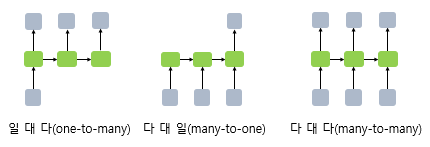

* 리뷰 감성 분류는 긍정/부정 하나의 분류이므로, RNN 다대일 구조이며, 이 경우 RNN 연산 결과는 n개 은닉 상태 중에서 마지막 번째만 선택

In [35]:
x_out = output[:, -1, :]
print(x_out)

tensor([[-0.6477, -0.5515, -0.8874,  0.9360,  0.3518, -0.3544,  0.1969,  0.7040,
          0.7838,  0.9015,  0.3021,  0.2159, -0.6491,  0.3018, -0.5585,  0.5743,
         -0.0343, -0.4258,  0.8133, -0.2039,  0.9046, -0.9173, -0.7659,  0.8209,
          0.6063, -0.7208, -0.0690, -0.7470,  0.2297,  0.9158,  0.4551, -0.8675,
         -0.7099,  0.5056, -0.8337,  0.5576,  0.6347, -0.0290,  0.3234,  0.8656,
         -0.1665, -0.6618, -0.0930, -0.2165, -0.4128,  0.3312, -0.8838, -0.5811,
          0.8708,  0.8002,  0.0334, -0.6721,  0.1329,  0.9255, -0.5492, -0.8813,
         -0.1483, -0.3118, -0.8593, -0.6132, -0.9289, -0.4215,  0.6261, -0.9349],
        [-0.6477, -0.5515, -0.8874,  0.9360,  0.3518, -0.3544,  0.1969,  0.7040,
          0.7838,  0.9015,  0.3021,  0.2159, -0.6491,  0.3018, -0.5585,  0.5743,
         -0.0343, -0.4258,  0.8133, -0.2039,  0.9046, -0.9173, -0.7659,  0.8209,
          0.6063, -0.7208, -0.0690, -0.7470,  0.2297,  0.9158,  0.4551, -0.8675,
         -0.7099,  0.5056, 

### dropout

In [36]:
dropout_p=0.5         # '0'은 dropout이 없고, '1'이면 모두 zero로 만듬
dropout = nn.Dropout(dropout_p)
x_out = dropout(x_out)
print(x_out)

tensor([[-1.2954, -0.0000, -0.0000,  0.0000,  0.0000, -0.0000,  0.3938,  1.4080,
          1.5675,  1.8031,  0.6043,  0.4318, -0.0000,  0.6037, -1.1171,  0.0000,
         -0.0686, -0.8517,  0.0000, -0.0000,  1.8093, -0.0000, -0.0000,  1.6419,
          1.2125, -0.0000, -0.1379, -0.0000,  0.4593,  1.8316,  0.0000, -0.0000,
         -0.0000,  0.0000, -0.0000,  0.0000,  1.2694, -0.0580,  0.0000,  0.0000,
         -0.0000, -1.3236, -0.0000, -0.0000, -0.8256,  0.6625, -0.0000, -1.1622,
          0.0000,  0.0000,  0.0668, -1.3441,  0.0000,  1.8511, -1.0984, -1.7626,
         -0.0000, -0.6235, -1.7187, -1.2264, -0.0000, -0.8431,  1.2522, -0.0000],
        [-1.2954, -0.0000, -0.0000,  0.0000,  0.7036, -0.0000,  0.3938,  1.4080,
          1.5675,  1.8031,  0.6043,  0.4318, -1.2982,  0.0000, -1.1171,  0.0000,
         -0.0000, -0.8517,  1.6265, -0.0000,  1.8093, -1.8346, -0.0000,  1.6419,
          0.0000, -0.0000, -0.0000, -0.0000,  0.0000,  1.8316,  0.9102, -0.0000,
         -0.0000,  1.0113, 

### Linear Regression test for Binary Selection

In [37]:
linear_test = nn.Linear(hidden_size, n_classes)
out=linear_test(x_out)
out

tensor([[ 0.2443, -0.5015],
        [ 0.5286, -0.4763],
        [ 1.1918, -0.4690],
        [-0.1570, -0.3682]], grad_fn=<AddmmBackward>)

In [38]:
# 가중치 확인
print(linear_test.weight.shape)
linear_test.weight

torch.Size([2, 64])


Parameter containing:
tensor([[-0.0351,  0.0067, -0.0173, -0.0635,  0.0814,  0.0863, -0.0431, -0.0899,
         -0.0134,  0.0978, -0.0422, -0.0151,  0.1090, -0.0160, -0.0334, -0.0112,
         -0.0052,  0.0647,  0.0691, -0.0737, -0.0336, -0.1198, -0.0648,  0.0670,
         -0.0921, -0.0759, -0.0680,  0.1029, -0.0674,  0.1144,  0.0967,  0.1032,
         -0.1186, -0.0465, -0.0963,  0.0907,  0.0992,  0.1186, -0.0615,  0.1202,
         -0.0750,  0.1171, -0.0396,  0.0631,  0.0475, -0.0762, -0.0116, -0.1097,
         -0.0971, -0.0257, -0.1155,  0.1131, -0.1057,  0.0859,  0.1166, -0.0639,
         -0.0426, -0.1192,  0.0105, -0.0587,  0.0616, -0.0389, -0.0465,  0.0014],
        [ 0.0083,  0.0878, -0.1011, -0.1065, -0.0709, -0.0362, -0.0658, -0.0083,
         -0.0487, -0.0203,  0.1249,  0.0667,  0.0062, -0.0700,  0.0802, -0.0187,
         -0.0455, -0.0304,  0.0104,  0.0442,  0.0819,  0.0046,  0.0354,  0.0593,
          0.0963, -0.0602,  0.0751, -0.0318, -0.0894, -0.0595, -0.0233,  0.0371,
     

### Cost function Test

In [39]:
F.cross_entropy(out, y)

tensor(0.6180, grad_fn=<NllLossBackward>)

## 7-6. Designing Model

### Simple Modeling

* 연산 순서: Embedding -> GRU (or RNN) -> binary Classification
* 긴 문장이되면 동일 하이파라미터 조건에서도 RNN보다 GRU가 우수하므로 아래는 GRU로 진행

In [40]:
class myModel(nn.Module):
    def __init__(self, hidden_size, n_vocab, embed_dim, n_classes, dropout_p, batch_first=True):    
        super(myModel, self).__init__()
        self.embedding_layer = nn.Embedding(num_embeddings=n_vocab, embedding_dim=embed_dim)
        self.gru_layer = nn.GRU(embed_dim, hidden_size, batch_first=batch_first)
        self.dropout = nn.Dropout(dropout_p)
        self.linear = nn.Linear(hidden_size, n_classes) 

    def forward(self, x):
        output = self.embedding_layer(x)
        output, hidden = self.gru_layer(output)
        x_out = self.dropout(output[:, -1, :])
        output = self.linear(x_out)
        return output

In [41]:
# 모델 생성
simple_model = myModel(hidden_size, n_vocab, embed_dim, n_classes, dropout_p, batch_first=True)

In [42]:
simple_model(x)           # x 입력하여 Model test

tensor([[ 0.2748,  0.2197],
        [ 0.1230,  0.0058],
        [ 0.4120, -0.5067],
        [-0.3325,  0.5508]], grad_fn=<AddmmBackward>)

In [43]:
optimizer = torch.optim.Adam(params=simple_model.parameters(), lr = 0.005)

### Model Training

In [45]:
for step in range(1, 21):
        for b, batch in enumerate(train_iter):
            x, y = batch.text.to(DEVICE), batch.label.to(DEVICE)
            y.data.sub_(1)  # 레이블 값을 0과 1로 변환
            optimizer.zero_grad()
            output = simple_model(x)
            loss = F.cross_entropy(output, y, reduction='sum')
            loss.backward()
            optimizer.step()
        if step % 4 == 0:
            print("[{:02d}/20] output is {}, y is {}, and loss is {:.4f} ".format(step, output.data, y, loss))

[04/20] output is tensor([[ 0.3669, -0.2164],
        [ 1.5354, -0.5557],
        [-0.2669, -0.1901],
        [-0.4342, -0.3179]]), y is tensor([0, 1, 0, 0]), and loss is 4.1362 
[08/20] output is tensor([[-2.3515,  2.5728],
        [-2.3579,  2.8697],
        [-2.2347,  2.0447],
        [-2.6190,  2.5609]]), y is tensor([1, 1, 1, 1]), and loss is 0.0320 
[12/20] output is tensor([[-2.5561,  3.4146],
        [-2.6607,  1.9399],
        [ 3.2835, -2.9064],
        [-4.5652,  4.3052]]), y is tensor([1, 1, 0, 1]), and loss is 0.0147 
[16/20] output is tensor([[ 3.5604, -3.2366],
        [ 2.6614, -3.4598],
        [ 3.2810, -1.6573],
        [-2.4014,  3.7117]]), y is tensor([0, 0, 0, 1]), and loss is 0.0127 
[20/20] output is tensor([[ 2.8117, -3.5328],
        [-4.3522,  4.1144],
        [-2.5390,  2.1856],
        [ 1.4785, -2.5598]]), y is tensor([0, 1, 1, 0]), and loss is 0.0283 


## 7-7. Model Evaluation

In [46]:
corrects, total_loss = 0, 0
for b, batch in enumerate(val_iter):
    x, y = batch.text.to(DEVICE), batch.label.to(DEVICE)
    y.data.sub_(1)
    output = simple_model(x)
    loss = F.cross_entropy(output, y, reduction='sum')
    total_loss += loss.item()
    corrects += (output.max(1)[1].view(y.size()).data == y.data).sum()
size = len(val_iter.dataset)
avg_loss = total_loss / size
avg_accuracy = 100.0 * corrects / size
print("val loss is {}, val accuracy is {}".format (avg_loss, avg_accuracy))

val loss is 3.159780145475739, val accuracy is 55.26315689086914


## 참고: Model의 가중치(Parameters) 분석

In [47]:
# Model 가중치
simple_model.parameters()

<generator object Module.parameters at 0x000001CE2FB5BBC8>

In [48]:
# 가중치 확인
list(simple_model.parameters())

[Parameter containing:
 tensor([[ 0.1545, -1.0168, -0.8931,  ..., -0.0169, -1.2699,  0.8142],
         [-0.1780,  0.3700,  0.7450,  ..., -0.5840,  0.8755, -0.3447],
         [-1.5603, -1.1133,  1.4238,  ...,  1.3853,  0.7623,  0.6323],
         ...,
         [ 0.1791, -1.3558,  0.7006,  ..., -2.8928,  0.4766,  0.2899],
         [ 1.6682,  0.6897, -0.6469,  ..., -0.9862,  1.3039, -0.8010],
         [-0.7036,  0.2249,  0.1881,  ...,  0.7784,  0.6586,  0.1922]],
        requires_grad=True),
 Parameter containing:
 tensor([[ 0.0077,  0.0372, -0.0958,  ..., -0.0263,  0.0365,  0.0744],
         [-0.0189, -0.0125, -0.0102,  ...,  0.1086,  0.0727, -0.1115],
         [ 0.2311, -0.0953, -0.1163,  ..., -0.2726,  0.1435,  0.0790],
         ...,
         [-0.0707,  0.0402, -0.1084,  ...,  0.1310, -0.0515,  0.0884],
         [-0.0569,  0.1675,  0.1259,  ...,  0.0121,  0.0911, -0.1529],
         [ 0.0524, -0.0799,  0.0901,  ...,  0.0204, -0.0948, -0.0949]],
        requires_grad=True),
 Parameter con

In [50]:
para = list(simple_model.parameters())
print('Embedding:', para[0].shape,'\n GRU: ', para[1].shape,
      '\n', para[2].shape, para[3].shape, para[4].shape,
       '\n Linear regression : ', para[5].shape,'\n', para[6].shape)
# Model 가중치에는 총 7개 요소가 있으며, 앞서 확인한 
# Embedding, RNN, Linear regression 등의 가중치가 모두 포함되었음을 알 수 있다.

Embedding: torch.Size([847, 128]) 
 GRU:  torch.Size([192, 128]) 
 torch.Size([192, 64]) torch.Size([192]) torch.Size([192]) 
 Linear regression :  torch.Size([2, 64]) 
 torch.Size([2])


In [55]:
# 가중치인 generator 동작 확인
para = next(simple_model.parameters()).data
print(para.shape,para)

torch.Size([847, 128]) tensor([[ 0.1545, -1.0168, -0.8931,  ..., -0.0169, -1.2699,  0.8142],
        [-0.1780,  0.3700,  0.7450,  ..., -0.5840,  0.8755, -0.3447],
        [-1.5603, -1.1133,  1.4238,  ...,  1.3853,  0.7623,  0.6323],
        ...,
        [ 0.1791, -1.3558,  0.7006,  ..., -2.8928,  0.4766,  0.2899],
        [ 1.6682,  0.6897, -0.6469,  ..., -0.9862,  1.3039, -0.8010],
        [-0.7036,  0.2249,  0.1881,  ...,  0.7784,  0.6586,  0.1922]])


In [62]:
# 가중치 차원 변형 방법
para.new(33, 5, 4)

tensor([[[3.4118e-10, 6.4740e-43,        nan,        nan],
         [0.0000e+00, 6.4740e-43, 8.4273e-13, 6.4740e-43],
         [2.2675e-04, 6.4740e-43, 2.2675e-04, 6.4740e-43],
         [2.2675e-04, 6.4740e-43, 5.6052e-45, 0.0000e+00],
         [2.6905e-43, 0.0000e+00, 3.4119e-10, 6.4740e-43]],

        [[3.4119e-10, 6.4740e-43, 3.4119e-10, 6.4740e-43],
         [       nan,        nan, 0.0000e+00, 6.4740e-43],
         [8.4273e-13, 6.4740e-43, 2.2675e-04, 6.4740e-43],
         [2.2675e-04, 6.4740e-43, 2.2675e-04, 6.4740e-43],
         [5.6052e-45, 0.0000e+00, 2.6905e-43, 0.0000e+00]],

        [[3.4121e-10, 6.4740e-43, 3.4121e-10, 6.4740e-43],
         [3.4121e-10, 6.4740e-43,        nan,        nan],
         [0.0000e+00, 6.4740e-43, 8.4273e-13, 6.4740e-43],
         [2.2675e-04, 6.4740e-43, 2.2675e-04, 6.4740e-43],
         [2.2675e-04, 6.4740e-43, 5.6052e-45, 0.0000e+00]],

        [[2.6905e-43, 0.0000e+00, 3.4123e-10, 6.4740e-43],
         [3.4123e-10, 6.4740e-43, 3.4123e-10, 6.47

In [63]:
# 가중치 초기화 방법
para.new(32, 5).zero_()

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])